In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io as sio

In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = VGG16(weights=None, include_top=False)

# features = model.predict(x)
model.load_weights('/Users/dan/proj/fbsear/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

/Users/dan/proj/fbsear/py3env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [17]:

img_path = '/Users/dan/proj/fbsear/images/train2017/000000387661.jpg'
img = image.load_img(img_path, target_size=(224, 224))
aimg = image.img_to_array(img)
x = np.expand_dims(aimg, axis=0)
x = preprocess_input(x)
y = model.predict(x)

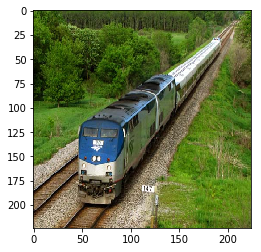

In [19]:
plt.imshow(img)

In [24]:
yflat = np.ndarray.flatten(y)

In [25]:
yflat

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [26]:
np.min(yflat)

0.0

In [27]:
np.max(yflat)

249.6114

In [28]:
import keras.backend as K


def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


def display_activations(activation_maps):
    import numpy as np
    import matplotlib.pyplot as plt
    """
    (1, 26, 26, 32)
    (1, 24, 24, 64)
    (1, 12, 12, 64)
    (1, 12, 12, 64)
    (1, 9216)
    (1, 128)
    (1, 128)
    (1, 10)
    """
    batch_size = activation_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
            if num_activations > 1024:  # too hard to display it on the screen.
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        plt.imshow(activations, interpolation='None', cmap='jet')
        plt.show()

In [68]:
a = get_activations(model,x)

----- activations -----
[[[[ -96.939 -107.779 -114.68 ]
   [-100.939 -111.779 -118.68 ]
   [ -98.939 -109.779 -116.68 ]
   ...
   [ -77.939  -88.779  -94.68 ]
   [ -99.939 -113.779 -118.68 ]
   [ -93.939 -107.779 -112.68 ]]

  [[ -89.939 -100.779 -107.68 ]
   [ -95.939 -106.779 -113.68 ]
   [ -97.939 -108.779 -115.68 ]
   ...
   [ -97.939 -108.779 -114.68 ]
   [ -93.939 -104.779 -110.68 ]
   [ -78.939  -92.779  -97.68 ]]

  [[ -90.939 -101.779 -108.68 ]
   [ -95.939 -106.779 -113.68 ]
   [ -93.939 -104.779 -111.68 ]
   ...
   [ -95.939 -106.779 -112.68 ]
   [ -84.939  -95.779 -101.68 ]
   [ -78.939  -89.779  -95.68 ]]

  ...

  [[  33.061    4.221   -9.68 ]
   [  22.061   -6.779  -20.68 ]
   [  18.061  -10.779  -24.68 ]
   ...
   [  10.061  -14.779  -23.68 ]
   [  15.061   -9.779  -18.68 ]
   [  20.061   -4.779  -13.68 ]]

  [[  16.061  -10.779  -23.68 ]
   [  24.061   -2.779  -15.68 ]
   [  24.061   -2.779  -15.68 ]
   ...
   [   3.061  -21.779  -30.68 ]
   [   9.061  -15.779  -22.68 

Displaying activation map 0


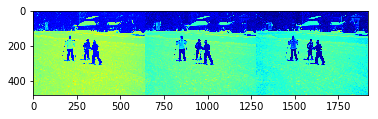

Displaying activation map 1


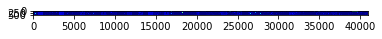

Displaying activation map 2


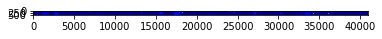

Displaying activation map 3


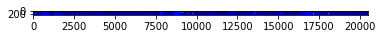

Displaying activation map 4


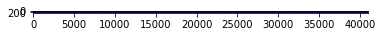

Displaying activation map 5


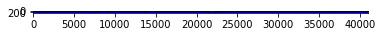

Displaying activation map 6


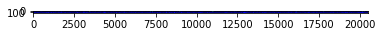

Displaying activation map 7


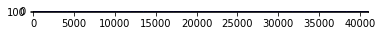

Displaying activation map 8


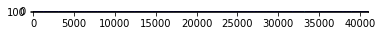

Displaying activation map 9


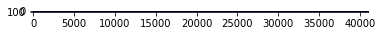

Displaying activation map 10


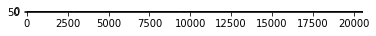

Displaying activation map 11


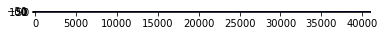

Displaying activation map 12


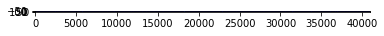

Displaying activation map 13


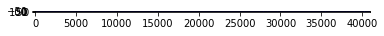

Displaying activation map 14


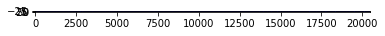

Displaying activation map 15


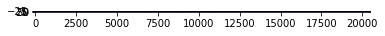

Displaying activation map 16


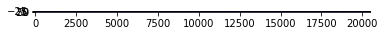

Displaying activation map 17


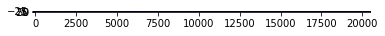

Displaying activation map 18


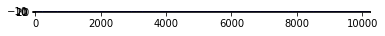

In [69]:
display_activations(a)

In [62]:
img = sio.loadmat('data/orig/person/img01')
cimg = img['cimg']

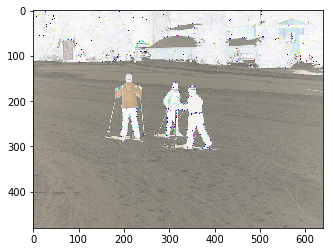

In [66]:
x = np.float64(cimg)
plt.imshow(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

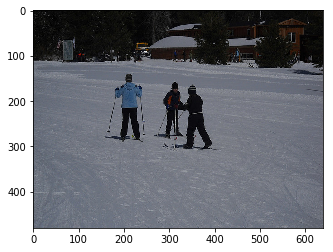

In [67]:
plt.imshow(cimg)

/Users/dan/proj/fbsear/py3env/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


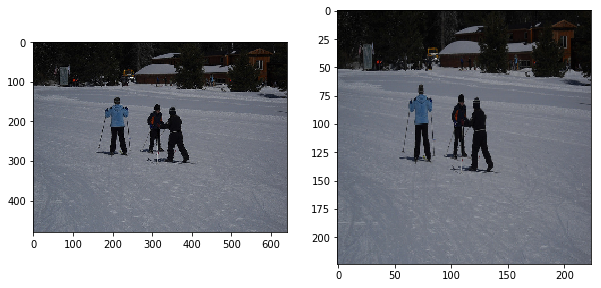

In [58]:
from skimage import transform as tf
nimg = tf.resize(cimg, (224, 224, 3), order=1) # order=1, bi-linear
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 10))
ax1.imshow(cimg)
ax2.imshow(nimg)
